# Script - B2W Challenge - Lucas Edler

## 1) Pré processamento dos dados

Importando bibliotecas

In [2]:
comp_prices<-read.csv("comp_prices.csv", sep = ",")
sales<-read.csv("sales.csv")

Cria conceito de preço unitário

In [3]:
sales$UNITARY_PRICE<-sales$REVENUE / sales$QTY_ORDER

Tratamento de dados: tabela comp_prices parece ter erros de input (alguns dados parecem estar multiplicados *100)

In [4]:
comp_prices_aux<-comp_prices[,c("COMPETITOR_PRICE","PROD_ID","DATE_EXTRACTION","COMPETITOR", "PAY_TYPE")]
names(comp_prices_aux)<-c("UNITARY_PRICE","PROD_ID","DATE_ORDER","SELLER","PAY_TYPE")
comp_prices_aux$UNITARY_PRICE<-ifelse(comp_prices_aux$UNITARY_PRICE>3000,comp_prices_aux$UNITARY_PRICE/100,comp_prices_aux$UNITARY_PRICE)

# 2) Modelagem

Produto 1 (P1)

In [5]:
sales_P1<-sales[sales$PROD_ID=="P1",c("DATE_ORDER","QTY_ORDER","UNITARY_PRICE")]

Criando matriz com dia, quantidade vendidade e preço médio de venda

In [6]:
aux<-aggregate(sales_P1$UNITARY_PRICE, by = list(sales_P1$DATE_ORDER), FUN = mean)
sales_P1<-aggregate(sales_P1$QTY_ORDER, by = list(sales_P1$DATE_ORDER), FUN = sum)
sales_P1<-merge(sales_P1,aux,by = "Group.1", all.x = TRUE)

Enriquecendo matriz com a informação do preço mínimo da concorrência

Pay type = 1 (vendas a prazo)

In [7]:
comp_prices_P1_M1<-comp_prices_aux[comp_prices_aux$PROD_ID=="P1" & comp_prices_aux$PAY_TYPE==1,c("DATE_ORDER","UNITARY_PRICE")]
comp_prices_P1_M1$DATE_ORDER<-as.Date(comp_prices_P1_M1$DATE_ORDER)
comp_prices_P1_M1$DATE_ORDER<-as.factor(comp_prices_P1_M1$DATE_ORDER)
aux<-aggregate(comp_prices_P1_M1$UNITARY_PRICE, by = list(comp_prices_P1_M1$DATE_ORDER), FUN = min)
sales_P1<-merge(sales_P1,aux,by = "Group.1", all.x = TRUE)

Pay type = 2 (vendas a vista)

In [8]:
comp_prices_P1_M2<-comp_prices_aux[comp_prices_aux$PROD_ID=="P1" & comp_prices_aux$PAY_TYPE==2,c("DATE_ORDER","UNITARY_PRICE")]
comp_prices_P1_M2$DATE_ORDER<-as.Date(comp_prices_P1_M2$DATE_ORDER)
comp_prices_P1_M2$DATE_ORDER<-as.factor(comp_prices_P1_M2$DATE_ORDER)
aux<-aggregate(comp_prices_P1_M2$UNITARY_PRICE, by = list(comp_prices_P1_M2$DATE_ORDER), FUN = min)
sales_P1<-merge(sales_P1,aux,by = "Group.1", all.x = TRUE)

Warning message in merge.data.frame(sales_P1, aux, by = "Group.1", all.x = TRUE):
"column names 'x.x', 'x.y' are duplicated in the result"

Renomeando colunas

In [9]:
names(sales_P1)<-c("Date","QTY","P_B2W","P_Comp_M1","P_Comp_M2")

Criando indicador: delta entre preço médio B2W e preços mínimos da concorrência

In [10]:
sales_P1$Diff_Price_Comp_M1<-sales_P1$P_B2W / sales_P1$P_Comp_M1 - 1
sales_P1$Diff_Price_Comp_M2<-sales_P1$P_B2W / sales_P1$P_Comp_M2 - 1

Evolução das vendas

In [11]:
ts.plot(sales_P1$QTY)

Comportamento da variação das vendas dia a dia (curva de vendas eliminada a tendência de longo prazo)

Podemos observar que as variações nas vendas costumam orbitar média = 0, o que denota um modelo do tipo Random Walk

In [12]:
ts.plot(diff(sales_P1$QTY))

## Análise de correlação

Podemos observar nos gráficos uma realação razoável entre quantidad e preço da B2W e uma relação fraca entre com o delta em relação aos preços da concorrência

In [13]:
pairs(sales_P1[,c("QTY","P_B2W","P_Comp_M1","P_Comp_M2","Diff_Price_Comp_M1","Diff_Price_Comp_M2")])

Como podemos ver, há uma relação de -0,5 em relação ao preço da B2W e de -0,32 em relação à difenrença entre o preço médio da B2W e preço mínimo praticado pela concorrência em vendas a vista

Isso signfica dizer que podemos esperar um aumento de 25% nas vendas se dermos 50% de desconto no preço.

In [14]:
cor(sales_P1[,c("QTY","P_B2W")])
cor(na.omit(sales_P1[,c("QTY","P_Comp_M1","P_Comp_M2","Diff_Price_Comp_M1","Diff_Price_Comp_M2")]))

QTY        P_B2W     
QTY    1.0000000 -0.5105572
P_B2W -0.5105572  1.0000000

QTY         P_Comp_M1   P_Comp_M2  Diff_Price_Comp_M1
QTY                 1.00000000  0.09879474  0.2108230 -0.2447594        
P_Comp_M1           0.09879474  1.00000000  0.8525264 -0.9194486        
P_Comp_M2           0.21082300  0.85252641  1.0000000 -0.8022109        
Diff_Price_Comp_M1 -0.24475940 -0.91944862 -0.8022109  1.0000000        
Diff_Price_Comp_M2 -0.32996960 -0.74483367 -0.9384171  0.8320142        
                   Diff_Price_Comp_M2
QTY                -0.3299696        
P_Comp_M1          -0.7448337        
P_Comp_M2          -0.9384171        
Diff_Price_Comp_M1  0.8320142        
Diff_Price_Comp_M2  1.0000000

## Analise de autocorrelação

O gráfico baixo nos mostra que as vendas em Tn são razoavelmente correlacionadas às vendas em Tn-1 (0.5) e pouco relacionadas às vendas em Tn-2 (0.29). Mas mesmo assim, a autocorrelação demora a decair a 0, reforçando a Autoregressão do modelo


Autocorrelations of series 'sales_P1$QTY', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000  0.506  0.291  0.211  0.162  0.192  0.228  0.190  0.090  0.039 -0.026 

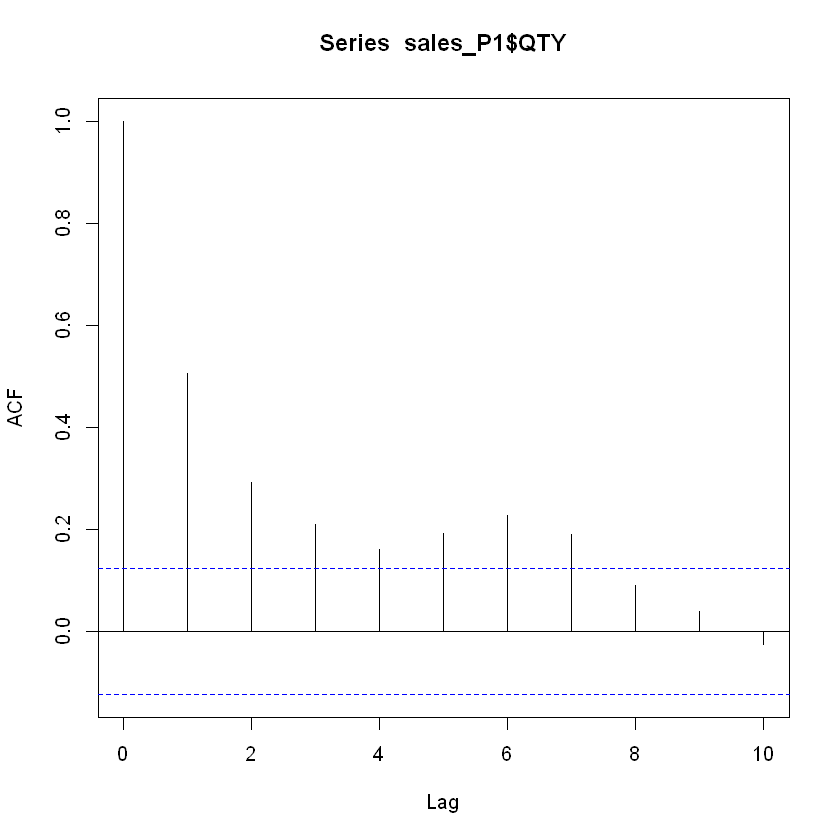

In [15]:
acf(sales_P1$QTY,lag.max = 10,plot = FALSE)
acf(sales_P1$QTY,lag.max = 10,plot = TRUE)

## Modelo de Autoregressão

In [16]:
AR_Model<-arima(sales_P1$QTY, order = c(1,0,0))
AR_fitted<-sales_P1$QTY - residuals(AR_Model)
ts.plot(sales_P1$QTY)
points(AR_fitted, type = "l", col = 2, lty = 2)

Realizando a previsão

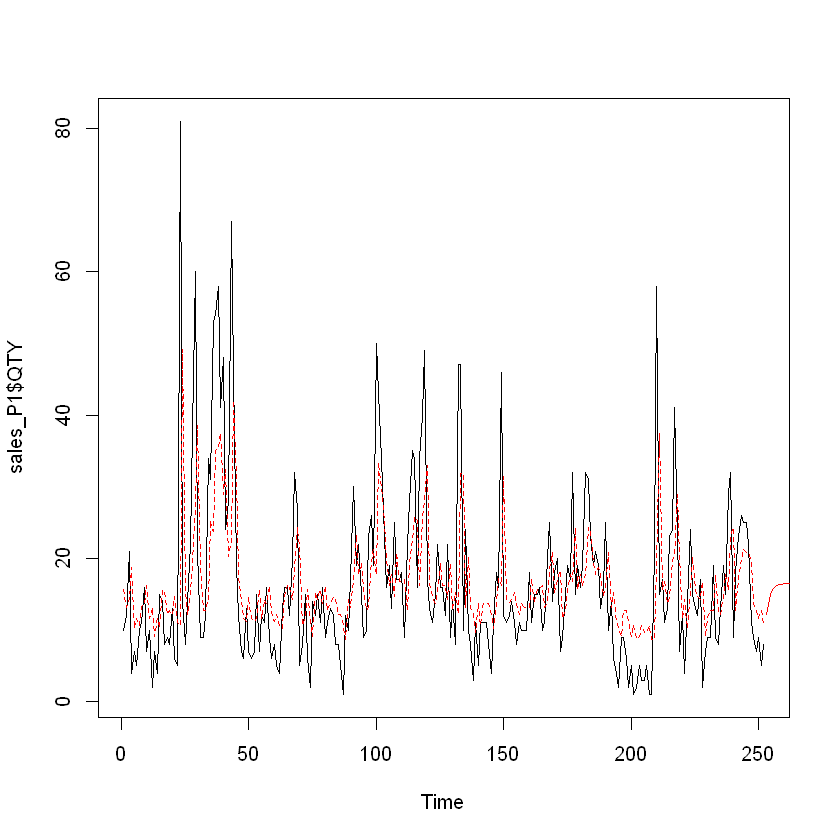

In [17]:
predict_AR<-predict(AR_Model,n.ahead = 30)
ts.plot(sales_P1$QTY)
points(AR_fitted, type = "l", col = 2, lty = 2)
points(predict_AR$pred, type = "l", col = 2)

## Modelo de média móvel simples

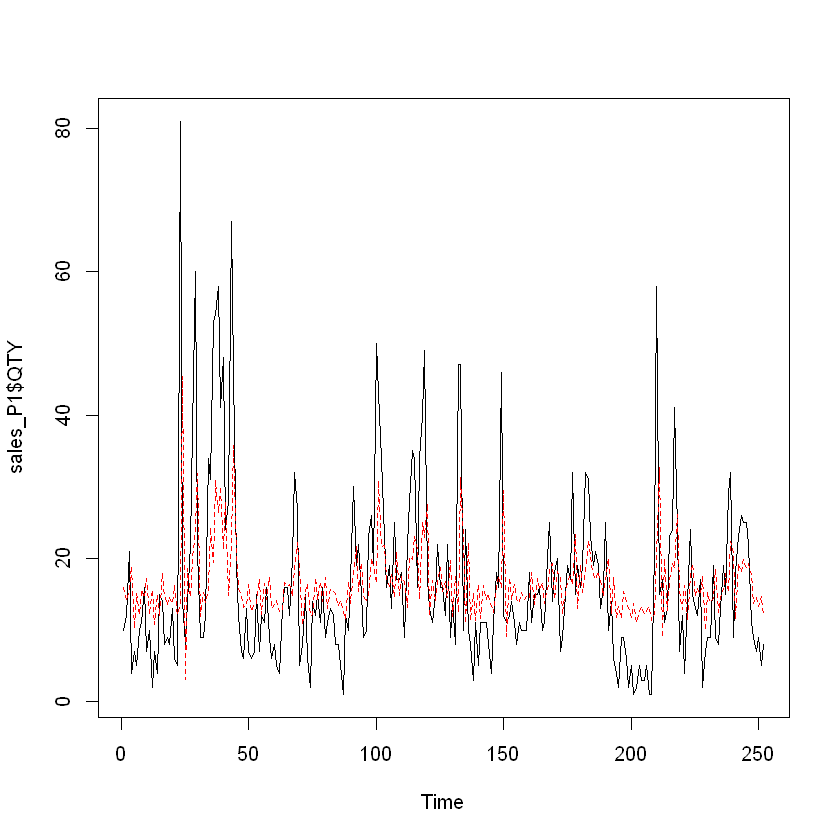

In [18]:
MA_Model<-arima(sales_P1$QTY, order = c(0,0,1))
MA_fitted<-sales_P1$QTY - residuals(MA_Model)
ts.plot(sales_P1$QTY)
points(MA_fitted, type = "l", col = 2, lty = 2)

Realizando previsão

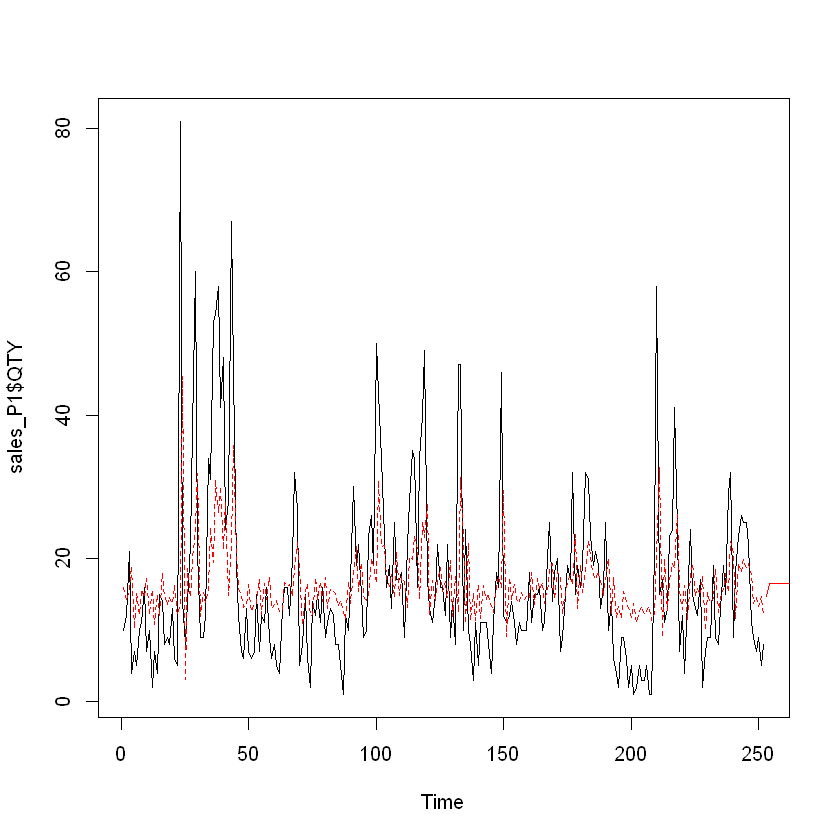

In [21]:
predict_MA<-predict(MA_Model,n.ahead = 30)
ts.plot(sales_P1$QTY)
points(MA_fitted, type = "l", col = 2, lty = 2)
points(predict_MA$pred, type = "l", col = 2)

Comparando os dois modelos

Os indicadores AIC (Akaika information criterion) e BIC (Bayesian information criterion) nos dão o poder preditivo do modelo, sendo aquele com menor índice, o melhor. O modelo de Autoressão parece ser levemente superior em ambos os casos.

In [20]:
cor(AR_fitted, MA_fitted)
paste("AIC_AR:",AIC(AR_Model))
paste("AIC_MA:",AIC(MA_Model))
paste("BIC_AR:",BIC(AR_Model))
paste("BIC_MA:",BIC(MA_Model))

[1] 0.9252411

[1] "AIC_AR: 1921.89027590239"

[1] "AIC_MA: 1938.15143126866"

[1] "BIC_AR: 1932.47856316492"

[1] "BIC_MA: 1948.7397185312"